In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from xgboost import plot_importance
from sklearn.feature_selection import RFECV

import xgboost as xgb
from comet_ml import Experiment
from comet_ml.integration.sklearn import log_model
import seaborn as sns
import pickle
import os


making Models Folder

In [2]:
if not os.path.exists('models/'):
    os.mkdir('models/')

Used functions

In [3]:
# https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
def train_test_split_season(df, seasons_train=[20162017, 20172018, 20182019], season_test=20192020):
    df_train = df[df['gameType']=='R'][df['season'].isin(seasons_train)]
    df_test = df[df['season'] == season_test]
    return df_train, df_test
    
def plot_roc_curve(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    fig = plt.gcf()
    plt.show()
    return fig
def plot_goal_rate_vs_percentile(y_true, y_prob, bins=10):
    percentiles = np.percentile(y_prob, np.linspace(0, 100, bins))
    avg_goal_rate = [np.mean(y_true[y_prob >= p]) for p in percentiles]

    plt.figure(figsize=(8, 6))
    plt.plot(percentiles, avg_goal_rate, marker='o')
    plt.xlabel('Probability Percentile')
    plt.ylabel('Goal Rate')
    plt.title('Goal Rate vs Probability Percentile')
    fig = plt.gcf()
    plt.show()
    return fig

def plot_cumulative_proportion_of_goals(y_true, y_prob, bins=10):
    percentiles = np.percentile(y_prob, np.linspace(0, 100, bins))
    cumulative_goals = [np.sum(y_true[y_prob >= p]) for p in percentiles]
    total_goals = np.sum(y_true)
    cumulative_proportion = np.cumsum(cumulative_goals) 
    cumulative_proportion = [element / total_goals for element in cumulative_proportion]
    plt.figure(figsize=(8, 6))
    plt.plot(percentiles, cumulative_proportion, marker='o')
    plt.xlabel('Probability Percentile')
    plt.ylabel('Cumulative Proportion of Goals')
    plt.title('Cumulative Proportion of Goals vs Probability Percentile')
    fig = plt.gcf()
    plt.show()
    return fig

def plot_reliability_curve(y_true, y_prob, bins=10):
    prob_bins = np.linspace(0, 1, bins + 1)
    centers = (prob_bins[:-1] + prob_bins[1:]) / 2

    empirical_prob = [np.mean(y_prob[(y_prob >= prob_bins[i]) & (y_prob < prob_bins[i+1])]) for i in range(bins)]
    fraction_of_positives = [np.mean(y_true[(y_prob >= prob_bins[i]) & (y_prob < prob_bins[i+1])]) for i in range(bins)]

    plt.figure(figsize=(8, 6))
    plt.plot(centers, empirical_prob, marker='o', label='Empirical')
    plt.plot(centers, fraction_of_positives, marker='o', linestyle='--', label='Fraction of Positives')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Reliability Curve')
    plt.legend()
    fig = plt.gcf()
    plt.show()
    return fig



Rading data

In [4]:
df = pd.read_csv("data/all_game_data_milesstone_2.csv")
train, test = train_test_split(df)
yy_test = test['is_goal']
test_game_type = test['gameType']

Beginning the Experiments

In [59]:
experiment = Experiment(api_key='h85xbEnyF7lyFkSRYhBshWV8E', project_name="nhl-data-science", workspace="mahmoodhegazy")


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: xgboost, sklearn.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/mahmoodhegazy/nhl-data-science/73b3615e1771430c8fd543a01f419049
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (38.40 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following mod

Baseline XGBOOST

handeling the data for this section

In [60]:

y = train['is_goal']
x = train[['shot_distance_to_goal', 'shot_angle']]
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=10)

Training the model


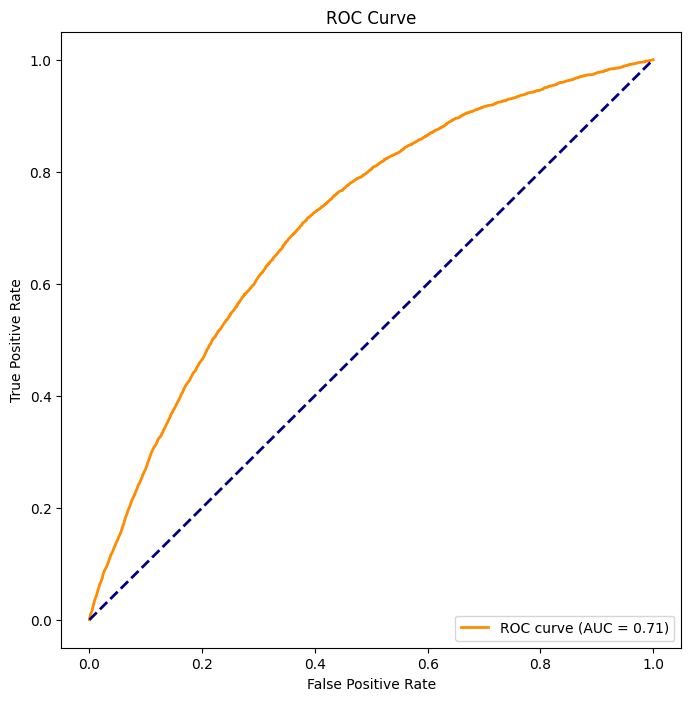

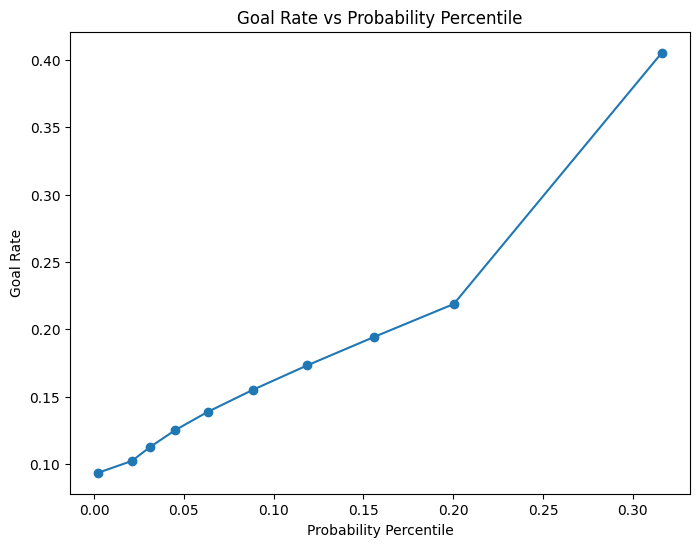

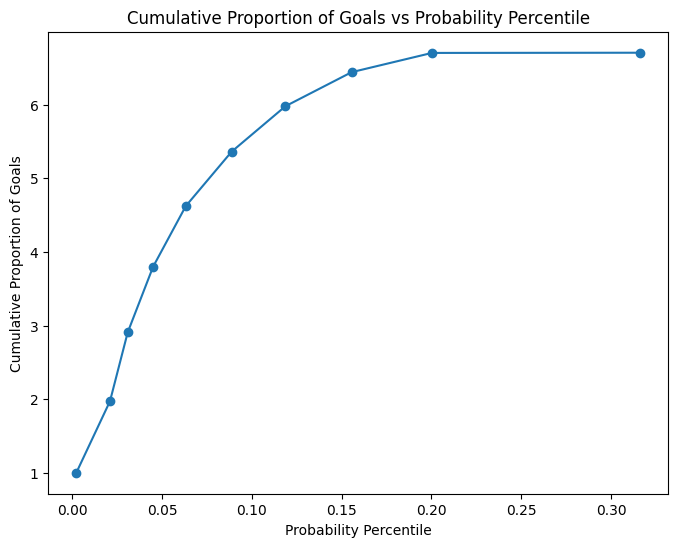

c:\Users\Mahdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Mahdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


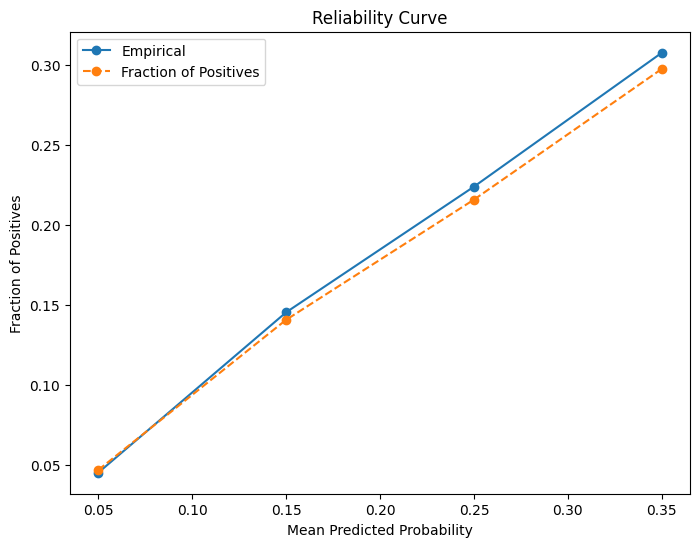

In [61]:
xgb_da = xgb.XGBClassifier()
xgb_da.fit(X_train, y_train)
preds = xgb_da.predict(X_val)


y_prob = xgb_da.predict_proba(X_val)[:, 1]

p1 = plot_roc_curve(y_val, y_prob)
p2=plot_goal_rate_vs_percentile(y_val, y_prob)
p3=plot_cumulative_proportion_of_goals(y_val, y_prob)
p4=plot_reliability_curve(y_val, y_prob)



Logging the experiments of Baseline

In [62]:
experiment.log_metric('accuracy', accuracy_score(y_val, preds))
experiment.log_metric('f1 score', f1_score(y_val, preds))
experiment.log_metric('ROC AUC score', roc_auc_score(y_val, preds))

experiment.log_figure(figure=p1, figure_name='ROC Curve with Distance and Angle', step=None)
experiment.log_figure(figure=p2,figure_name='Goal Rate with Distance and Angle', step=None)
experiment.log_figure(figure=p3,figure_name='Cumulative goal % with Distance and Angle', step=None)
experiment.log_figure(figure=p4,figure_name='Calibration curve with Distance and Angle', step=None)

pickle.dump(xgb_da, open("models/XGBOOST-baseline.sav", "wb"))
experiment.log_model("XGBOOST-Baseline", "models/XGBOOST-baseline.sav")

{'web': 'https://www.comet.com/api/asset/download?assetId=e2e1b0b09f0b4216a31a5dffa5167760&experimentKey=e9dd7470c82c4cc6be538c2342409b28',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=e2e1b0b09f0b4216a31a5dffa5167760&experimentKey=e9dd7470c82c4cc6be538c2342409b28',
 'assetId': 'e2e1b0b09f0b4216a31a5dffa5167760'}

XGBOOST with all the features


Handeling the data for this section

In [7]:
X_cols = ['game_seconds', 'game_period', 'x_coordinate', 'y_coordinate', 'shot_distance_to_goal', 'shot_angle', 'shot_type',
'last_x_coordinate', 'last_y_coordinate', 'last_event', 'time_from_last_event', 'distance_from_last_event', 'rebound', 'speed',
'time_since_powerplay_started', 'num_friendly_non_goalie_skaters', 'num_opposing_non_goalie_skaters']
y_cols = ['is_goal']
train_val, y = train[X_cols], train[y_cols]


train_val['rebound'] = train_val['rebound'].astype(int)
train_val['last_event'] = pd.Categorical(train_val['last_event'])
onehot_encoded_df = pd.get_dummies(train_val, columns=['last_event'], prefix='last_event')

onehot_encoded_df['shot_type'] = pd.Categorical(onehot_encoded_df['shot_type'])
onehot_encoded_df = pd.get_dummies(onehot_encoded_df, columns=['shot_type'], prefix='shot_type')

train_val = onehot_encoded_df.fillna(0).astype(int)
ftrain_val = train_val
ftrain_val['is_goal'] = y.fillna(0)

C:\Users\Mahdi\AppData\Local\Temp\ipykernel_14608\422543663.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_val['rebound'] = train_val['rebound'].astype(int)
C:\Users\Mahdi\AppData\Local\Temp\ipykernel_14608\422543663.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_val['last_event'] = pd.Categorical(train_val['last_event'])


In [8]:
X_cols_test = ['game_seconds', 'game_period', 'x_coordinate', 'y_coordinate', 'shot_distance_to_goal', 'shot_angle', 'shot_type',
'last_x_coordinate', 'last_y_coordinate', 'last_event', 'time_from_last_event', 'distance_from_last_event', 'rebound', 'speed',
'time_since_powerplay_started', 'num_friendly_non_goalie_skaters', 'num_opposing_non_goalie_skaters']
y_cols_test = ['is_goal']
x_test, y_test = test[X_cols_test], test[y_cols_test]


x_test['rebound'] = x_test['rebound'].astype(int)
x_test['last_event'] = pd.Categorical(x_test['last_event'])
x_test_onehot_encoded_df = pd.get_dummies(x_test, columns=['last_event'], prefix='last_event')

x_test_onehot_encoded_df['shot_type'] = pd.Categorical(x_test_onehot_encoded_df['shot_type'])
x_test_onehot_encoded_df = pd.get_dummies(x_test_onehot_encoded_df, columns=['shot_type'], prefix='shot_type')

x_test = x_test_onehot_encoded_df.fillna(0).astype(int)
ftest = x_test
ftest['is_goal'] = yy_test.fillna(0)
ftest['game_type'] = test_game_type

C:\Users\Mahdi\AppData\Local\Temp\ipykernel_14608\2913646004.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['rebound'] = x_test['rebound'].astype(int)
C:\Users\Mahdi\AppData\Local\Temp\ipykernel_14608\2913646004.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['last_event'] = pd.Categorical(x_test['last_event'])


In [16]:
ftest.to_csv('data/xgboost_test_data.csv')
ftrain_val.to_csv('data/xgboost_train_data.csv')

In [64]:
X_train, X_val, y_train, y_val = train_test_split(train_val, y, test_size=0.2, random_state=10)


Training the model


In [65]:
xgb_da = xgb.XGBClassifier()
xgb_da.fit(X_train, y_train)
preds = xgb_da.predict(X_val)
y_prob = xgb_da.predict_proba(X_val)[:,1]


Plotting the results

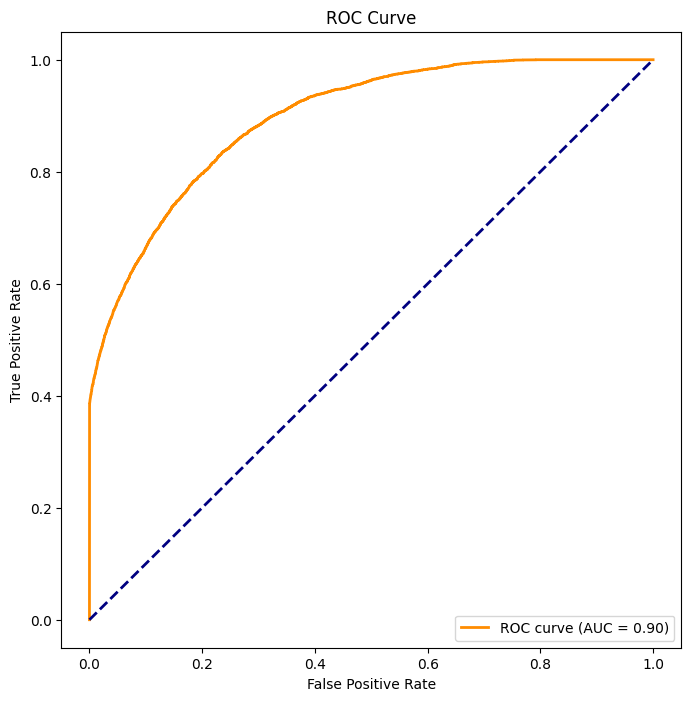

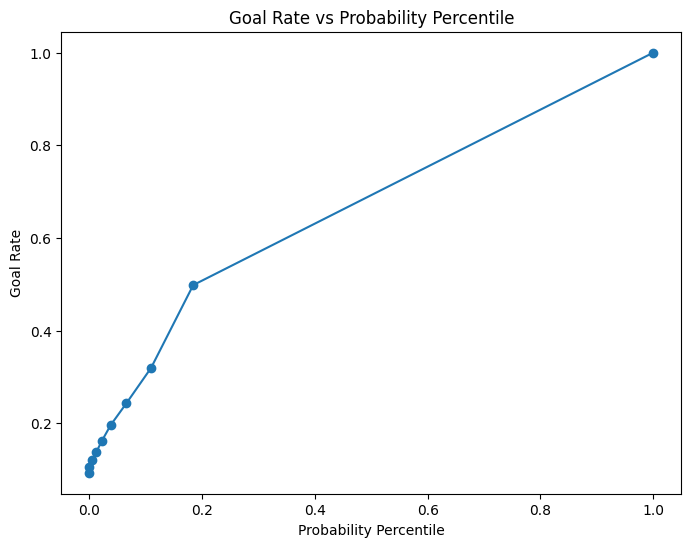

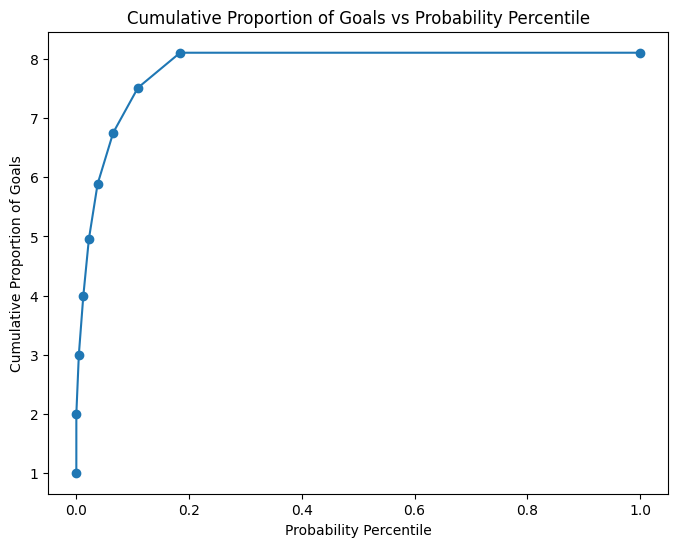

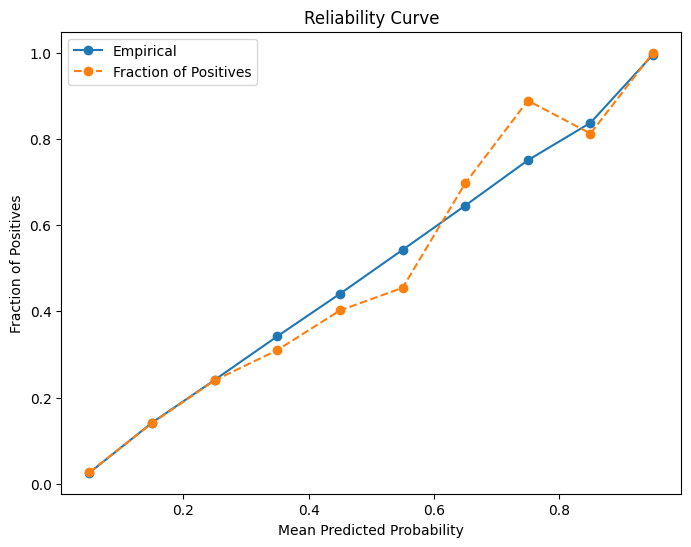

In [66]:

p1 = plot_roc_curve(y_val, y_prob)
p2 = plot_goal_rate_vs_percentile(y_val, y_prob)
p3 = plot_cumulative_proportion_of_goals(y_val, y_prob)
p4 = plot_reliability_curve(y_val, y_prob)

Hyper parameter tuning

In [67]:
#  https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 6, 7],
}

xgb_da = xgb.XGBClassifier()
grid_search = GridSearchCV(
    xgb_da,
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_xgb_da = grid_search.best_estimator_
preds = best_xgb_da.predict(X_val)
accuracy = accuracy_score(y_val, preds)
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score'].reshape(len(param_grid['learning_rate']), -1)



Fitting 3 folds for each of 27 candidates, totalling 81 fits


Plot the results

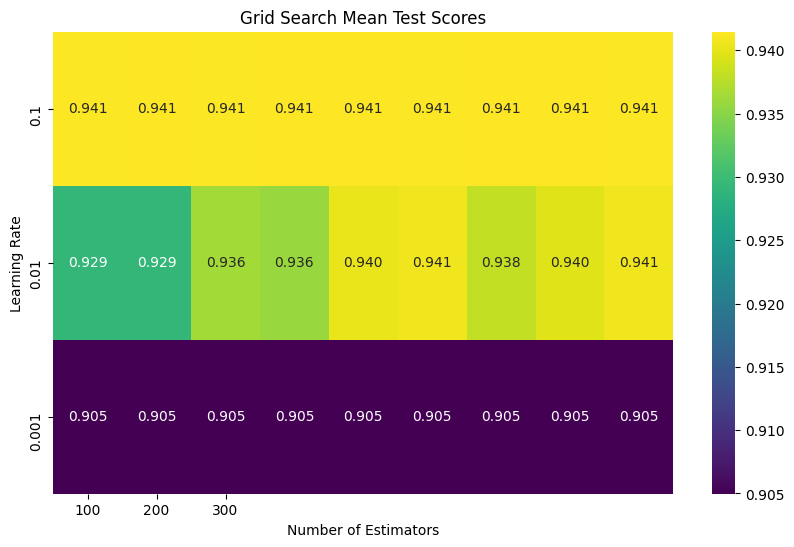

In [68]:

plt.figure(figsize=(10, 6))
sns.heatmap(
    mean_test_scores,
    annot=True,
    cmap='viridis',
    xticklabels=param_grid['n_estimators'],
    yticklabels=param_grid['learning_rate'],
    fmt=".3f",  
)
plt.title('Grid Search Mean Test Scores')
plt.xlabel('Number of Estimators')
plt.ylabel('Learning Rate')
f1 = plt.gcf()
plt.show()

Hyper parameter tuning

In [69]:
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 6, 7],
}
xgb_da = xgb.XGBClassifier()

grid_search = GridSearchCV(
    xgb_da,
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_xgb_da = grid_search.best_estimator_
preds = best_xgb_da.predict(X_val)
accuracy = accuracy_score(y_val, preds)
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score'].reshape(len(param_grid['learning_rate']), -1)


Fitting 3 folds for each of 27 candidates, totalling 81 fits


Plot the results

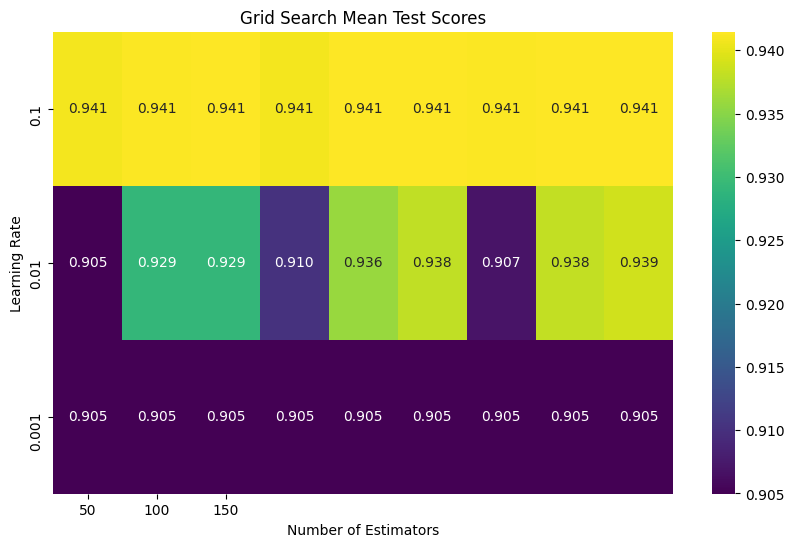

In [70]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    mean_test_scores,
    annot=True,
    cmap='viridis',
    xticklabels=param_grid['n_estimators'],
    yticklabels=param_grid['learning_rate'],
    fmt=".3f",  
)

plt.title('Grid Search Mean Test Scores')
plt.xlabel('Number of Estimators')
plt.ylabel('Learning Rate')
f1 = plt.gcf()
plt.show()

Hyper parameter tuning

In [71]:
param_grid = {
    'learning_rate': [10,1,0.1, 0.01, 0.001],
    'n_estimators': [100, 150,200],
    'max_depth': [7, 8, 9, 10],
}
xgb_da = xgb.XGBClassifier()

grid_search = GridSearchCV(
    xgb_da,
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_xgb_da = grid_search.best_estimator_
preds = best_xgb_da.predict(X_val)
accuracy = accuracy_score(y_val, preds)
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score'].reshape(len(param_grid['learning_rate']), -1)



Fitting 3 folds for each of 60 candidates, totalling 180 fits


Plotting the results

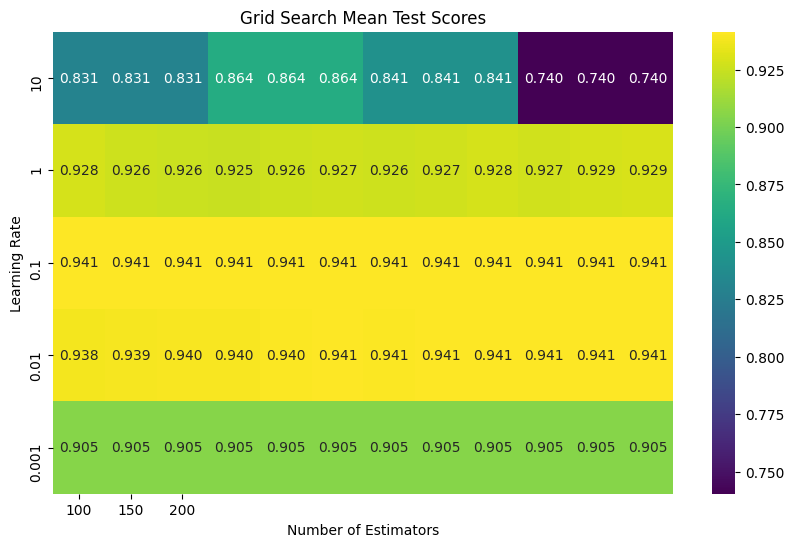

In [72]:

plt.figure(figsize=(10, 6))
sns.heatmap(
    mean_test_scores,
    annot=True,
    cmap='viridis',
    xticklabels=param_grid['n_estimators'],
    yticklabels=param_grid['learning_rate'],
    fmt=".3f",  
)

plt.title('Grid Search Mean Test Scores')
plt.xlabel('Number of Estimators')
plt.ylabel('Learning Rate')
f1 = plt.gcf()
plt.show()

Hyper parameter tuning

In [73]:
param_grid = {
    'learning_rate': [0.1],
    'n_estimators': [100],
    'max_depth': [8],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}
xgb_da = xgb.XGBClassifier()

grid_search = GridSearchCV(
    xgb_da,
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_xgb_da = grid_search.best_estimator_
preds = best_xgb_da.predict(X_val)
accuracy = accuracy_score(y_val, preds)
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score'].reshape(len(param_grid['learning_rate']), -1)



Fitting 3 folds for each of 27 candidates, totalling 81 fits


Plotting the results

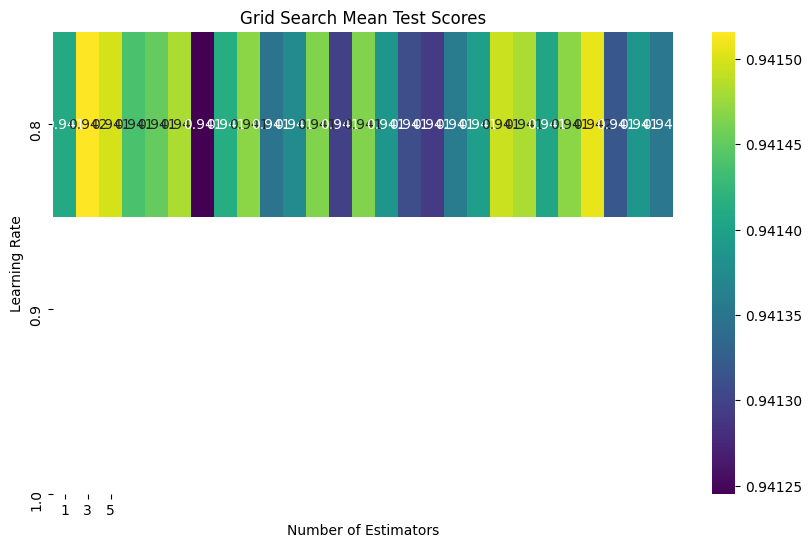

In [74]:

plt.figure(figsize=(10, 6))
sns.heatmap(
    mean_test_scores,
    annot=True,
    cmap='viridis',
    xticklabels=param_grid['min_child_weight'],
    yticklabels=param_grid['subsample'],
    fmt=".3f",  
)

plt.title('Grid Search Mean Test Scores')
plt.xlabel('Number of Estimators')
plt.ylabel('Learning Rate')
f1 = plt.gcf()
plt.show()

Best XGBOOST

In [75]:

hyperparameters = {
    'learning_rate': 0.1,
    'n_estimators': 100,
    'max_depth': 8,
    'min_child_weight': 1,
    'subsample': 1.0,
    'colsample_bytree': 0.9
}

xgb_da = xgb.XGBClassifier(**hyperparameters)
xgb_da.fit(X_train, y_train)
preds = xgb_da.predict(X_val)
accuracy = accuracy_score(y_val, preds)
y_prob = xgb_da.predict_proba(X_val)[:, 1]



plotting the resutls 

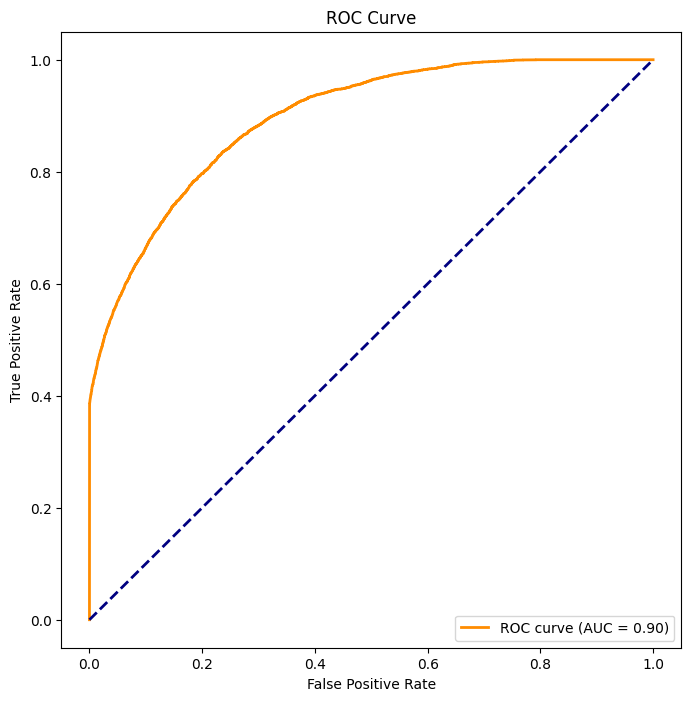

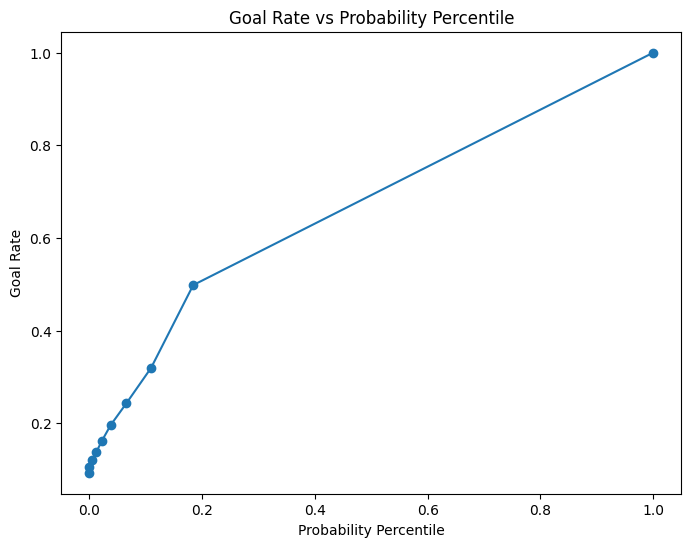

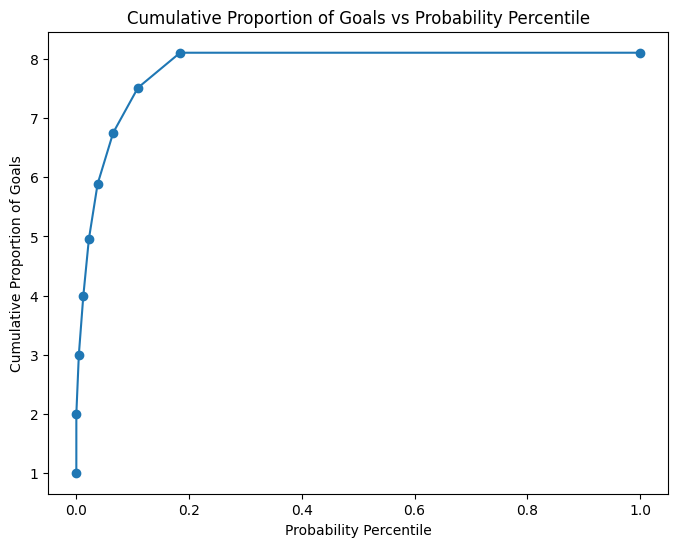

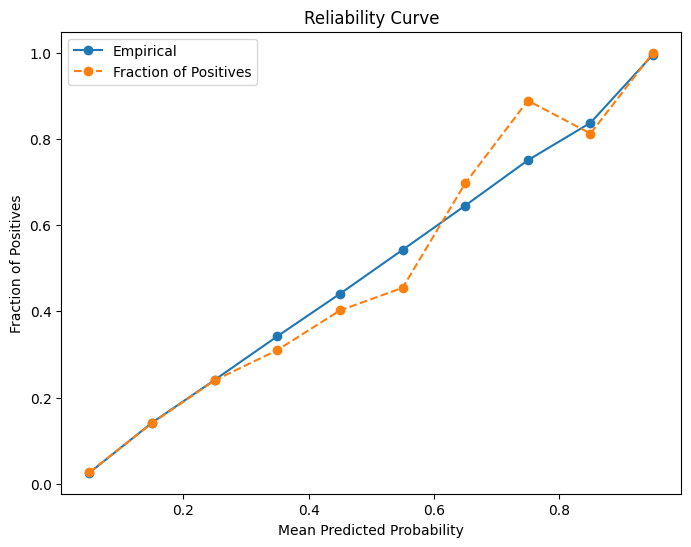

In [76]:
p1 = plot_roc_curve(y_val, y_prob)
p2=plot_goal_rate_vs_percentile(y_val, y_prob)
p3=plot_cumulative_proportion_of_goals(y_val, y_prob)
p4=plot_reliability_curve(y_val, y_prob)


Logging the Best XGBOOST

In [77]:
experiment.log_metric('accuracy', accuracy_score(y_val, preds))
experiment.log_metric('f1 score', f1_score(y_val, preds))
experiment.log_metric('ROC AUC score', roc_auc_score(y_val, preds))
experiment.log_figure(figure=p1, figure_name='ROC Curve with Distance and Angle', step=None)
experiment.log_figure(figure=p2,figure_name='Goal Rate with Distance and Angle', step=None)
experiment.log_figure(figure=p3,figure_name='Cumulative goal % with Distance and Angle', step=None)
experiment.log_figure(figure=p4,figure_name='Calibration curve with Distance and Angle', step=None)
pickle.dump(xgb_da, open("models/XGBOOST-best.sav", "wb"))
experiment.log_model("XGBOOST-best", "models/XGBOOST-best.sav")


{'web': 'https://www.comet.com/api/asset/download?assetId=715a41b972d848e6b9e9d72177b20c83&experimentKey=e9dd7470c82c4cc6be538c2342409b28',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=715a41b972d848e6b9e9d72177b20c83&experimentKey=e9dd7470c82c4cc6be538c2342409b28',
 'assetId': '715a41b972d848e6b9e9d72177b20c83'}

Feature selection

Training the model

In [78]:
hyperparameters = {
    'learning_rate': 0.1,
    'n_estimators': 100,
    'max_depth': 8,
    'min_child_weight': 1,
    'subsample': 1.0,
    'colsample_bytree': 0.9
}

xgb_da = xgb.XGBClassifier(**hyperparameters)

xgb_da.fit(X_train, y_train)
print("model trained succesfully")

model trained succesfully


1. Correlation Analysis:


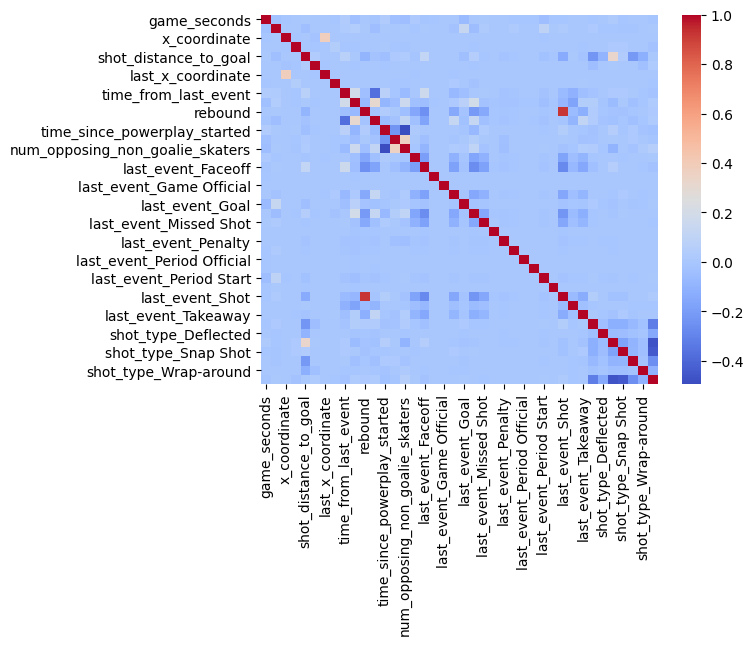

In [79]:
corr_matrix = X_train.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', fmt=".2f")
plt.show()

2. Feature Importance with XGBoost:



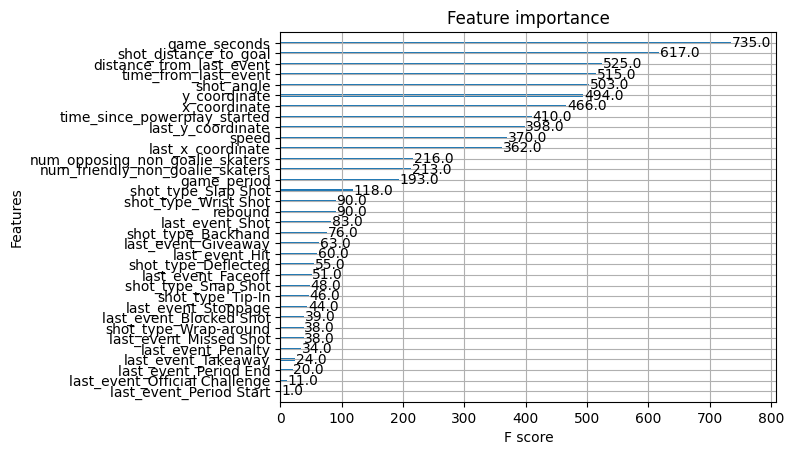

In [80]:
xgb.plot_importance(xgb_da)
plt.show()

In [81]:
feature_importance = xgb_da.feature_importances_

k = 10
top_k_features = feature_importance.argsort()[-k:][::-1]

X_train_selected = X_train.iloc[:, top_k_features]
X_val_selected = X_val.iloc[:, top_k_features]

xgb_da_selected = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=8,
    min_child_weight=1,
    subsample=1.0,
    colsample_bytree=0.9
)

xgb_da_selected.fit(X_train_selected, y_train)
preds_selected = xgb_da_selected.predict(X_val_selected)
accuracy_selected = accuracy_score(y_val, preds_selected)
print("Validation Accuracy with selected features: {:.2f}%".format(accuracy_selected * 100))


Validation Accuracy with selected features: 94.21%


3. SHAP 

[14:21:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


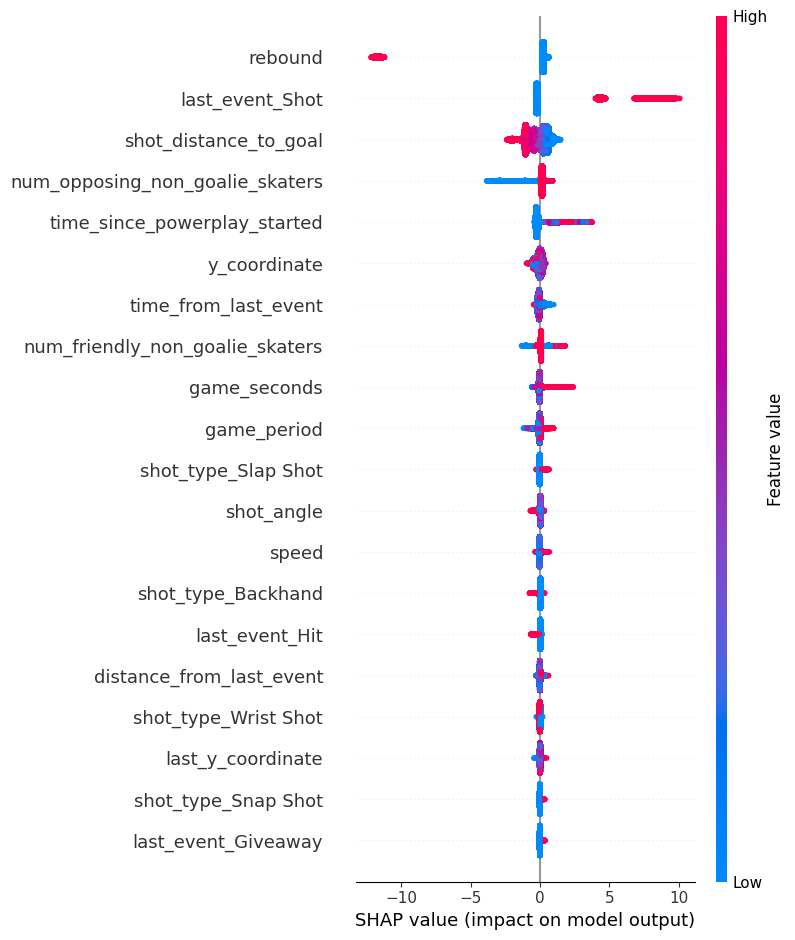

In [82]:
import shap

explainer = shap.TreeExplainer(xgb_da)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

4. Recursive Feature Addition

In [83]:
rfecv = RFECV(estimator=xgb_da, step=1, cv=5)
rfecv.fit(X_train, y_train)

print("Optimal number of features: %d" % rfecv.n_features_)

Optimal number of features: 25


Selecting the features

In [84]:
selected_features = X_train.columns[rfecv.support_]
selected_features

Index(['game_seconds', 'game_period', 'y_coordinate', 'shot_distance_to_goal',
       'shot_angle', 'time_from_last_event', 'distance_from_last_event',
       'rebound', 'speed', 'time_since_powerplay_started',
       'num_friendly_non_goalie_skaters', 'num_opposing_non_goalie_skaters',
       'last_event_Faceoff', 'last_event_Giveaway', 'last_event_Hit',
       'last_event_Penalty', 'last_event_Period End', 'last_event_Shot',
       'last_event_Stoppage', 'shot_type_Backhand', 'shot_type_Deflected',
       'shot_type_Slap Shot', 'shot_type_Snap Shot', 'shot_type_Wrap-around',
       'shot_type_Wrist Shot'],
      dtype='object')

Making the data

In [85]:
X_train_optimal = X_train[selected_features]
X_val_optimal = X_val[selected_features]

XGBOOST with optimal set of features

In [86]:
hyperparameters = {
    'learning_rate': 0.1,
    'n_estimators': 100,
    'max_depth': 8,
    'min_child_weight': 1,
    'subsample': 1.0,
    'colsample_bytree': 0.9
}

xgb_da = xgb.XGBClassifier(**hyperparameters)
xgb_da.fit(X_train_optimal, y_train)
preds = xgb_da.predict(X_val_optimal)
accuracy = accuracy_score(y_val, preds)
experiment.log_metric('accuracy', accuracy_score(y_val, preds))
experiment.log_metric('f1 score', f1_score(y_val, preds))
experiment.log_metric('ROC AUC score', roc_auc_score(y_val, preds))



y_prob = xgb_da.predict_proba(X_val_optimal)[:, 1]



Plotting the optimal features

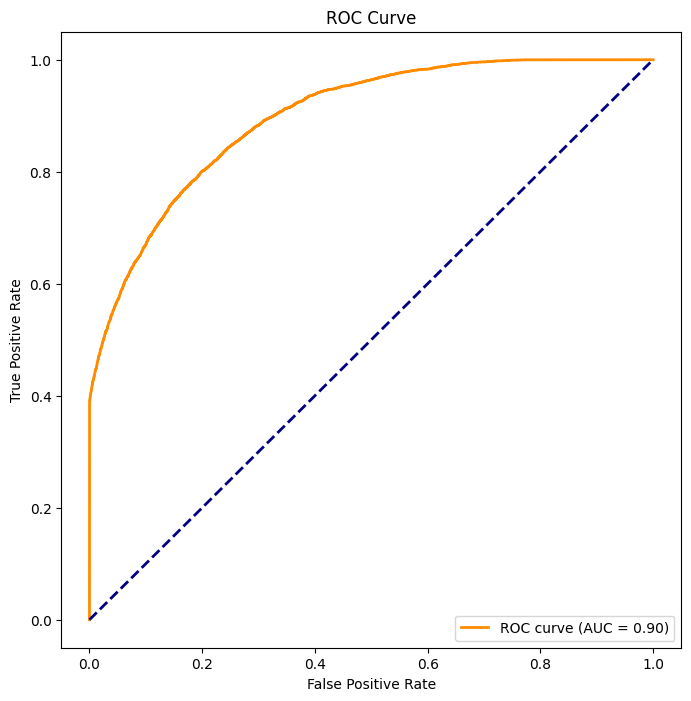

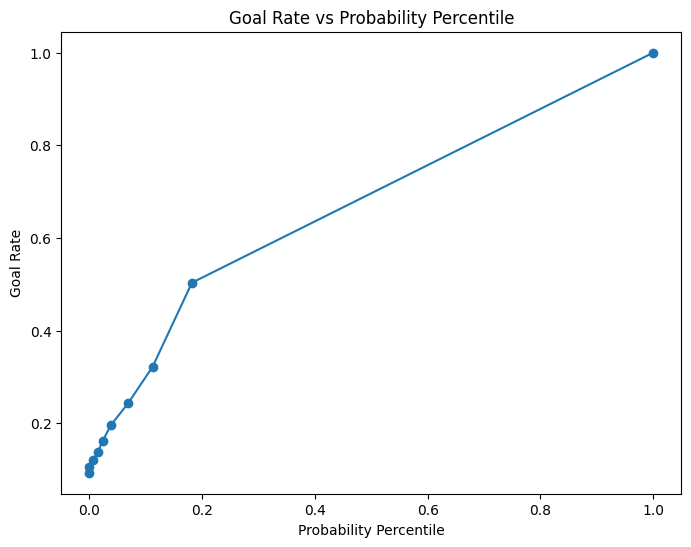

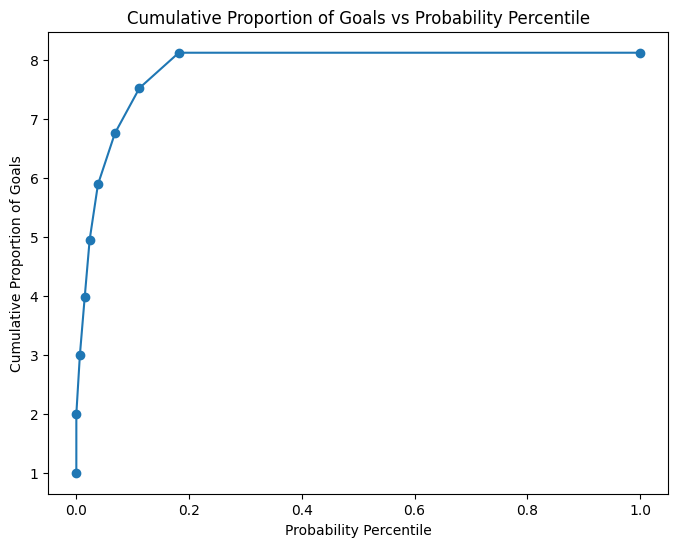

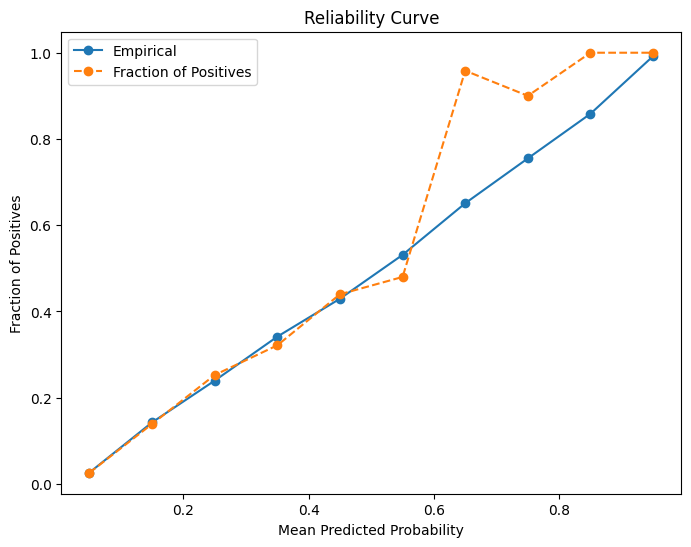

In [87]:
p1 = plot_roc_curve(y_val, y_prob)
p2=plot_goal_rate_vs_percentile(y_val, y_prob)
p3=plot_cumulative_proportion_of_goals(y_val, y_prob)
p4=plot_reliability_curve(y_val, y_prob)


Logging the optimal features

In [ ]:
experiment.log_figure(figure=p1, figure_name='ROC Curve with Distance and Angle', step=None)
experiment.log_figure(figure=p2,figure_name='Goal Rate with Distance and Angle', step=None)
experiment.log_figure(figure=p3,figure_name='Cumulative goal % with Distance and Angle', step=None)
experiment.log_figure(figure=p4,figure_name='Calibration curve with Distance and Angle', step=None)
pickle.dump(xgb_da, open("models/XGBOOST-optimal.sav", "wb"))
experiment.log_model("XGBOOST-optimal", "models/XGBOOST-optimal.sav")

experiment.end()